## DreliaCalc LOC Report

In [1]:
import arrow
dateformat='DD.MM.YYYY - HH:mm'
print(arrow.now('Europe/Vienna').format(dateformat))

03.02.2021 - 13:57


In [2]:
%cd /opt/notebooks/dmyplant2
!git pull --rebase

/opt/notebooks/dmyplant2
Already up to date.
Current branch master is up to date.


In [3]:
%cd ../dReliaCalc
import dmyplant2
import pandas as pd
import numpy as np
from pprint import pprint as pp

/opt/notebooks/dReliaCalc


In [4]:
dval = pd.read_csv("input.csv",sep=';', encoding='utf-8')
dval['val start'] = pd.to_datetime(dval['val start'], format='%d.%m.%Y')
failures = pd.read_csv("failures.csv",sep=';', encoding='utf-8')
failures['date'] = pd.to_datetime(failures['date'], format='%d.%m.%Y')

In [5]:
from dmyplant2 import cred
mp = dmyplant2.MyPlant(7200)
vl = dmyplant2.Validation(mp,dval, cui_log=False)                   

In [25]:
import ipywidgets as widgets
from IPython.display import display
le = vl.engines[0]

w = widgets.Dropdown(
    options=['Pick Engine'] + [e.__str__() for e in vl.engines],
    value='Pick Engine',
    description='Engine:',
)
def on_change(change):
    global le
    if change['type'] == 'change' and change['name'] == 'value':
        le = vl.eng_serialNumber(change['new'][:7])
        print(le)
w.observe(on_change)
display(w)


Dropdown(description='Engine:', options=('Pick Engine', '1145166 M02 POLYNT - 2 (1145166- ..', '1175579 M05 RE…

1320090 M01 BMW LANDSHUT M1        
1320114 M03 BMW LANDSHUT 4.10      


In [30]:
from pprint import pprint as pp
id = le.id
print(le)

1320114 M03 BMW LANDSHUT 4.10      


In [32]:
# fetch Lube Oil Consuption data
locdef = {227: 'OilConsumption', 
          237: 'DeltaOpH',
          228: 'OilVolume', 
          225: 'ActiveEnergy', 
          226: 'AvgPower'}

limit = 2500

# call myplant
dfr = le.batch_hist_dataItems(itemIds=locdef, p_limit=2500 ,timeCycle=30)

# Set Type of time column to DateTime
df = dfr
df['datetime'] = pd.to_datetime(df['time'] * 1000000)

# Filter to Validation Period
df = df[df.datetime > pd.to_datetime(le._d['val start'])]
print(dfr['time'].count(), df['time'].count())


# Filter Oil Consumption outliers by < 3 * stdev
df = df[np.abs(df.OilConsumption-df.OilConsumption.mean())
        <= (3*df.OilConsumption.std())]

# Calc Rolling Mean values
df['LOC'] = df.OilConsumption.rolling(50).mean()
df['Pow'] = df.AvgPower.rolling(50).mean()


2325 675


(1000.0, 5000.0)

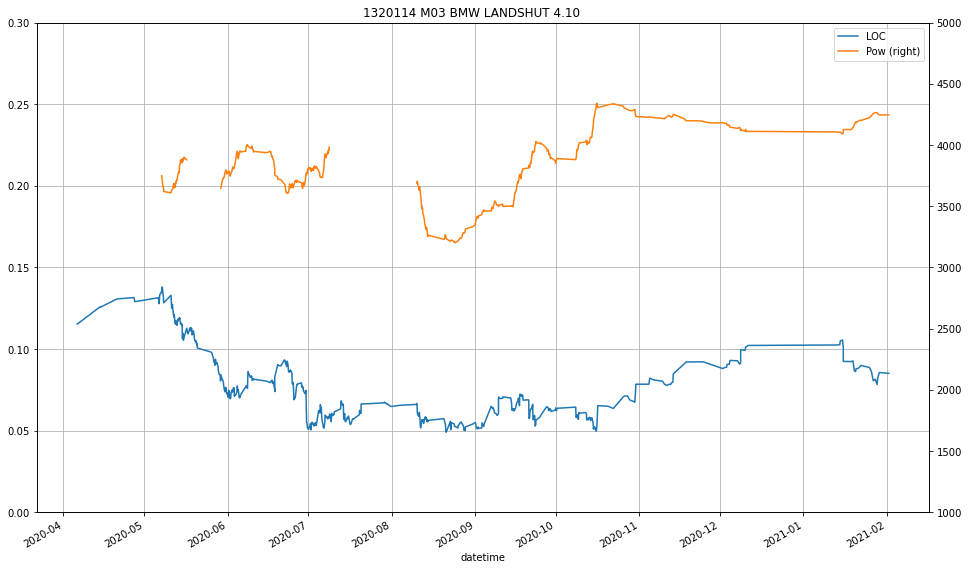

In [33]:
dfl=df[['datetime','OilConsumption','LOC','AvgPower','Pow']]
dfl=df[['datetime','LOC','Pow']]
ax = dfl.plot(subplots=False, x='datetime', secondary_y=['AvgPower','Pow'], ylim=(0,0.3), figsize=(16,10), title=le, grid=True)
ax.set_ylim(1000,5000)

In [52]:
#parameters
tdef = {161: 'CountOph', 102: 'PowerAct'}
#tlimit = 2500

#tfrom = arrow.get(le.valstart_ts)
#tfrom = arrow.get('2020-02-07')
tfrom = arrow.now('Europe/Vienna').shift(months=-2) 
#tfrom = arrow.now('Europe/Vienna').shift(days=-2)

#tto = arrow.now('Europe/Vienna')
#tto = arrow.get(2021,1,23,16,0)
tto=arrow.now('Europe/Vienna')

ttimecycle='1800'
#tassetType='J-Engine'
#tincludeMinMax='false'
#tforceDownSampling='false'

In [53]:
df = le.batch_hist_dataItems(itemIds=tdef, p_from=tfrom, p_to=tto,timeCycle=ttimecycle)
# Set Type of time column to DateTime
df['datetime'] = pd.to_datetime(df['time'] * 1000000)
df['CountOph'] = df.CountOph - le._d['oph@start']

# Just include the data to plot
dfp = df[['datetime','CountOph','PowerAct']]
print(dfp.tail(3))
dfp['datetime'].count()

                datetime  CountOph  PowerAct
2973 2021-02-03 11:30:00    3355.0       0.0
2974 2021-02-03 12:00:00    3355.0       0.0
2975 2021-02-03 12:30:00    3355.0       0.0


2976

<AxesSubplot:title={'center':'1320114 M03 BMW LANDSHUT 4.10      '}, xlabel='datetime'>

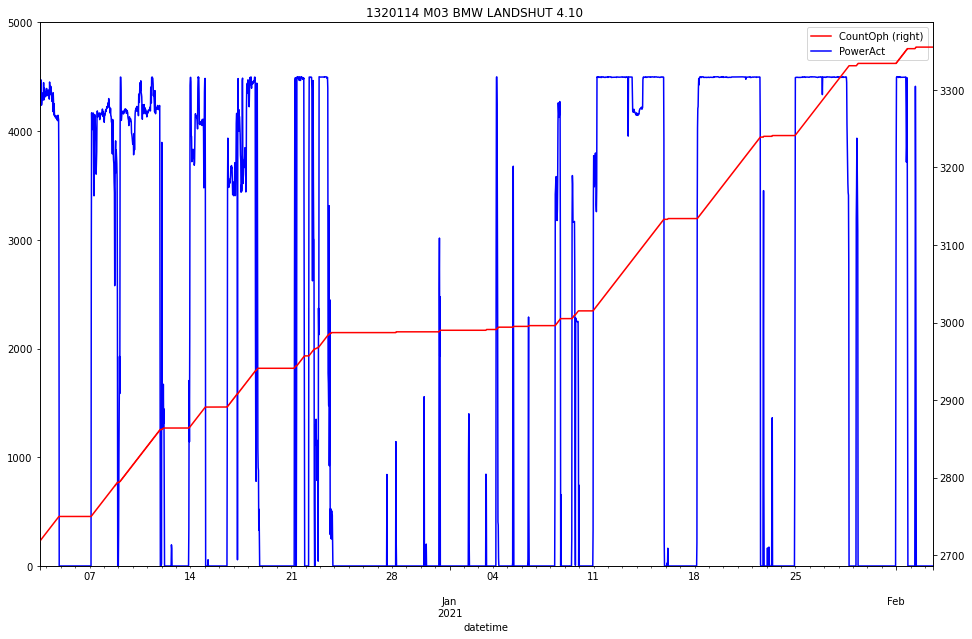

In [54]:
dfp.plot(subplots=False, x='datetime', color=['red','blue'], secondary_y = ['CountOph'],ylim=(0,5000), figsize=(16,10), title=le)
